# MeToo, a catalyst for change ? 
## ___Study of the influence of the movement on women's mediatic representation___

*This notebook resumes the work and data-pipeline achieved for Milestone 3, including Milestone 2.*

*The beginning of this Notebook consists in our Milestone 2 notebook, which contains the main methods used to deal with the raw data, process it, and extract the main figures which will let us conduct our analysis. The second part addresses the progress made since the Milestone 2 and analyses in depth the datasets constructed for Milestone 2. This helped us build our datastory.*

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Imports](#Imports)\
        C. [Paths](#Paths)\
</br> 

1. [Step 1: Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Creation of subset D1 and D2](#creation)\
        B. [Analyse Parquet File](#parquet1)\
        C. [Create datasets - mix Parquet (AD1) and Quotebank](#parquet2)\
        D. [Irregularities in data](#irreg)\
</br> 

2. [Step 2: General preliminary analysis using Quotebank entire dataset](#Step-2)\
        A. [Gender weekly counts on Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset (D1)](#Step-2-A)\
        B. [Gender weekly percentage on Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset (D1)](#Step-2-B)\
</br>

3. [Step 3: Generate annual and monthly word clouds based on general women coverage dataset (D2)](#Step-3)\
        A. [Running a word cloud per month on general women coverage dataset (D2)](#Step-3-A)\
        B. [Running a word cloud for period before MeToo and period after MeToo on general women coverage dataset (D2)](#Step-3-B)\
        C. [Running a wordcloud for each year on general women coverage dataset (D2)](#Step-3-C)\
</br> 


4. [Step 4: Investigate general women perception via general women coverage in medias (D2)](#Step-4)\
        A. [SpaCy model training on AD2 for classifying the quotes as misogynistic or non misogynistic](#Step-4-A)\
        B. [Predictions of misogynistic or non-misogynistic quotes on general women coverage in medias (D2)](#Step-4-B)\
        C. [Topic extraction on general women coverage in medias (D2)](#Step-4-C)\
</br> 

5. [Step 5-6:  Investigate gender and generational biases in general women coverage  (D2 - Step 5) and in MeToo coverage (D1 - Step 6) using NLP](#Step-5-6)\
        A. [Sentiment analysis on D1 and D2 - Subdivision into sets D1.2 and D2.2, per age categories](#Step-5-6-A)\
        B. [Sentiment analysis on D1 and D2 - Computation of the mean compound per gender](#Step-5-6-B)\
</br> 
  
6. [Step 7: Correlate and investigate causation between MeToo general perception and women’s mediatic place](#Step-7)\
        A. [Statistical analysis of differences in percentage of women speakers for Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset(D1), before and after MeToo](#Step-7-A)\
        B. [Sentiment analysis on D1 and D2 - Computation of the mean compound per gender](#Step-7-B)\
        C. [Statistical analysis of sentiment compounds evolution for different genres and age categories](#Step-7-C)

---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

TODO

***Files and directories to make this notebook run successfully:***

- **data/**
  - **parquet/**
    - *speaker_attributes.parquet*
    - *wikidata_labels_descriptions_quotebank.csv.bz2*
  - **filtered/**
    - **pickles/**
      - *quotes-2020-filtered.pkl.bz2*
    - *quotes-2020-filtered.json.bz2*
  - *quotes-2020.json.bz2*
- *data_processing.ipynb*
- *helper.py*



Directories are in **bold** and files are in *italic*.



### Imports <a id="Imports"> </a>

***Libraries used:***
- python=3.8.12
- pandas
- datetime
- time
- matplotlib
- seaborn
- pickle
- bz2
- json
- nltk
- numpy
- spacy
- sklearn
- re
- plotly
- string
- sys

In [ ]:
import bz2
import json
import pickle

import re
import sys
import os
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import PIL 
import wordcloud 

import nltk
import spacy
import plotly.graph_objects as go
import plotly.offline as pyo
import scipy.cluster.hierarchy as spc
import plotly.io as pio
import plotly.express as px

from os import path
from time import time
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from scipy import stats
from scipy import signal
from matplotlib.pyplot import figure
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from plotly.graph_objs import *

import gensim, sklearn
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.models import LdaMulticore
from numpy.random import seed as random_seed
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, './code')
import helper
from wordcloud_helper import *
from percentage_analysis import *
from compound_analysis import *


### Paths <a id="Paths"> </a>

Required to adapt those path to local file organization
> They are in `.format()` format in order to be yearly adaptable\
> see `helper.py` for path declaration

In [2]:
PATH_DATA = helper.PATH_DATA
PATH_QUOTEBANK = helper.PATH_QUOTEBANK

# Step 1.A)
PATH_QUOTE_WOMEN         = helper.PATH_QUOTE_WOMEN
PATH_QUOTE_WOMEN_MONTHLY = helper.PATH_QUOTE_WOMEN_MONTHLY
PATH_QUOTE_METOO         = helper.PATH_QUOTE_METOO
PATH_QUOTE_METOO_MONTHLY = helper.PATH_QUOTE_METOO_MONTHLY

# Step 1.B)
PATH_PARQUET = PATH_DATA + 'parquet/'
PARQUET_FILE = PATH_PARQUET + 'speaker_attributes.parquet'
WIKIDATA_LABELS_FILE = PATH_PARQUET + 'wikidata_labels_descriptions_quotebank.csv.bz2'
PATH_DATA_GENDER = PATH_DATA + 'Quotebank/genders.json.bz2'

In [3]:
YEARS = range(2015, 2020+1)
YEARS_CMP = [2015, 2017, 2019] # years for comparaison "before|during|after" #MeToo movment

---
## **Step 1: Data scraping, pre-processing and dataset construction** <a id="Step-1"> </a>

### A) <u>Creation of subset D1 and D2</u> <a id="creation"> </a>

Create subset D1 (metoo related) and D2 (women related) as subset of *Quotebank Dataset*.
> Create D2 first as D1 is a subset of D2

***D2***\
keep quotes which contains word that are in *women* related `helper.keywords`

In [ ]:
for year in YEARS:
    src_path = PATH_QUOTEBANK.format(year)
    dst_path = PATH_QUOTE_WOMEN.format(year)
    helper.generate_data_keyword(src_path, dst_path, helper.keywords)

We have run the parsing code for every year in `[2015;2020]` and we got the following results:

Year | Original Size | Filtered Size | Pickle Size | Time to filter |
:---:|:-------------:|:-------------:|:-----------:|:--------------:|
2020 |792.3 MB       |59.7 MB        |55 MB        |6 min 47s       |
2019 |3.32 GB        |345.4 MB       |318.2 MB     |39 min 5s       |
2018 |4.48 GB        |462.6 MB       |425.8 MB     |52 min 14s      |
2017 |4.84 GB        |447.6 MB       |411.2 MB     |50 min 30s      |
2016 |2.16 GB        |210.1 MB       |193.1 MB     |23 min 42s      |
2015 |3.11 GB        |293 MB         |269.2 MB     |33 min 1s       |
Total|18.7 GB        |1.82 GB        |1.67 GB      |3h 25 min 19s   |

*N.B: file sizes correspond to the .bz2 compressed files and they depend on the compression algorithm in each OS.*

create a separate file for each month of D2 (*women*)

In [ ]:
for year in YEARS:
    src_path = PATH_QUOTE_WOMEN.format(year)
    dst_path = PATH_QUOTE_WOMEN_MONTHLY.format(year, year) + '_{}.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, helper.keywords)

***D1***\
keep quotes which contains word that are in *metoo* related dict (subset of D2)

In [4]:
keywords_metoo = helper.people_dict\
          .union(helper.metoo_dict)\
          .union(helper.action_dict)

for year in YEARS:
    src_path = PATH_QUOTE_WOMEN.format(year)
    dst_path = PATH_QUOTE_METOO.format(year)
    helper.generate_data_keyword(src_path, dst_path, keywords_metoo)

create a separate file for each month of D1 (*metoo*)

In [ ]:
for year in YEARS:
    src_path = PATH_QUOTE_METOO.format(year)
    dst_path = PATH_QUOTE_METOO_MONTHLY.format(year, year) + '_{}_metoo.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, keywords_metoo)

### B) <u>Analyse Parquet File</u> <a id="run"> </a> <a id="parquet1"> </a>

***Load Speaker's Metadata from the parquet file***\
contains QIDs of *Quotebank*'s speakers, their gender, nationality and others speaker's informations. 

In [5]:
%%time
df_parquet = pd.read_parquet(PARQUET_FILE)
# columns:
# | aliases | date_of_bitrh | nationality | gender | lastrevid | ethnic_group | US_congress_bio_ID | occupation | party | academic_degree | id | label | candidacy | type | religion |
df_parquet.sample(3)

CPU times: user 19.9 s, sys: 3.86 s, total: 23.8 s
Wall time: 18.9 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
4916926,None,[+1994-11-30T00:00:00Z],[Q30],[Q6581097],1382885176,None,None,[Q937857],None,None,Q23883994,Brendan Hines-Ike,None,item,None
1392129,None,None,None,[Q6581097],964450118,None,None,[Q170790],None,None,Q12276632,None,None,item,None
2832135,[Eric Muller],None,None,None,1363136364,None,None,[Q1650915],None,None,Q57059837,Eric A Muller,None,item,None


In [79]:
%%time
df_parquet = pd.read_parquet(PARQUET_FILE)
# | aliases | date_of_bitrh | nationality | gender | lastrevid | ethnic_group | US_congress_bio_ID | occupation | party | academic_degree | id | label | candidacy | type | religion |
df_parquet.head()

CPU times: user 19.4 s, sys: 4 s, total: 23.4 s
Wall time: 18.4 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


We notice that QID's are unique as expected, but not labels and descriptions which can also be non-defined (*i.e.* NaN)

**NOTE:** The counts above are differents because for a given QID, there might not exist every metadata possible (*e.g.* an author might not belong to a political party)

***Load the QID's of present instances in Quotebank***\
link QIDs with their label and descriptions

***Load the QID's of present instances in Quotebank*** 

It contains QID's of speakers, their gender, nationality and others if present. 

In [9]:
print(df_qid.describe().loc[['count', 'unique']])
df_qid.sample(3)

          QID  Label Description
count   36969  32951       24542
unique  36969  31462       17029


,QID,Label,Description
14134,Q33298,Filipino,national and official language of the Philippines
16750,Q7928160,Viduthalai Chiruthaigal Katchi,Dravidian Tamil Nationalist political party
4025,Q62060692,Navarra Suma,electoral alliance in Navarre


***Analysis of Speaker's Genders***\
As we will group quotes by their speaker's gender, we first study their genders, which are available in the given parquet file

We notice that QID's are unique as expected, but not labels and descriptions which can also be non-defined (*i.e.* NaN)

<a id='error2'></a>
**NOTE:** We can notice some irregularities in the data: some QID's considered as genders are not really genders.
- **Queer, homosexuality:** Sexual orientation
- **Erkek, Gorō:** Family Names
- **Taira no Kiyomori:** Japanese Samurai
- **Male/female organism:** Not really an irregularity but since speakers are human, it should not exist as a gender in the database

There are also two QID's that correspond to transgender male/female when searching manually for them online, but they are not classified as such in the given wikidata file. A cause of this might be the fact that there already exists a QID for transgender males/females. Therefore, we will not drop them.

Check for the 1st row of `df_gender`: A gender that is defined somewhere in parquet file, but not in wikidata labels file

In [18]:
# Gender is declared in gender's parquet file:
df_parquet[df_parquet.id == df_gender.iloc[0].speaker_qids]

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3040274,"[Anne P. O'Brien, Anne O'Brien]",[+1954-00-00T00:00:00Z],[Q408],"[Q6581072, Q15145782]",1395620619,None,None,"[Q201788, Q1622272, Q482980]",None,None,Q78971059,Anne Philomena O'Brien,None,item,None


In [19]:
# but not labeled: empty output
df_qid[df_qid.QID == df_gender.iloc[0].gender_qids]

,QID,Label,Description


Hand searching for second gender of QID *Q78971059* : [Q15145782](https://www.wikidata.org/wiki/Q15145782)'s label is also *transgender female*, which is a redirection to the labaled [Q1052281](https://www.wikidata.org/wiki/Q1052281) QID

Write result (`df_gender`) in json file for later use

In [6]:
df_gender.reset_index().to_json(PATH_DATA_GENDER, orient='records', lines=True)  # need to reset index because indexes are string... lost when wrote

In [6]:
# Write result in json file
df_gender.reset_index().to_json(PATH_DATA_GENDER, orient='records', lines=True)  # need to reset index because previous index was string... lost when write

### C) <u>Create datasets - mix Parquet (AD1) and Quotebank</u> <a id="parquet2"> </a>

***Read dataframes from 2.*** \
No need to run if [this part](#run) has already been run.

In [4]:
# Read Parquet and gender
df_parquet = pd.read_parquet(PARQUET_FILE)

# Read Gender fom parquet analysis
df_gender = pd.read_json(PATH_DATA_GENDER, orient='records', lines=True)
df_gender.set_index('gender_names', inplace=True)

***Create list and dataframe for datasets*** \
those are used when splitting dataset per gender, and counting weekly numbers of quotations

In [5]:
# list of genders QIDs
wrong_genders = ['Erkek', 'Gorō', 'Taira no Kiyomori', 'queer', 'homosexuality'] # genders that are not considered as gender by us (see Part 1.B)
qid_male    = [df_gender.loc['male'].gender_qids]
qid_female  = [df_gender.loc['female'].gender_qids]
qids_others = df_gender.drop(['male', 'female'] + wrong_genders)[['gender_qids']].gender_qids
qids_wrong  = df_gender.loc[wrong_genders].gender_qids

# Create dataframe to record weekly count of quotations per genders
col_weekly    = ['male', 'female', 'others','wrong', 'none', 'speaker_noParquet', 'speaker_None', 'all']
idx_weekly    = [i for i in range(1, 54)] # Represents 53 weeks (52 full + last incomplete, which is the 1st week of the following year)
df_weekly_count = pd.DataFrame(0, index=idx_weekly, columns=col_weekly)

# column kept when merging Parquet and Quotebank
quote_column = ['quoteID','quotation','speaker','qids','date']
parquet_column = ['date_of_birth', 'gender', 'party', 'id']
df_selected_parquet = df_parquet[parquet_column]

***Monthly Male quotes from D2 (*women*) in 2020*** \
Subset used later for misoginy analysis. (see Step 4)

In [16]:
helper.create_D2_male_2020(quote_column, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)

### D) <u>Irregularities in data</u> <a id="irreg"> </a>

***1. Speaker not repertiored:***

Get speaker QID from \[speaker_noMeta\] and input it in \[df_parquet\] as follow:
``` python
i = 0
df_parquet[df_parquet.id == speaker_noMeta.iloc[i].values[0]]
```
> should return an empty DataFrame

Example:

i = 0 : [Q59209387](https://www.wikidata.org/wiki/Q59209387) does not exist\
i = 1 : [Q30337200](https://www.wikidata.org/wiki/Q30337200) Philippe Bouyer 

***2. Gender not described:***

*See first two rows of output of this [cell](#error1)*

If the link does not work, it is the output of python cell number 13.

***3. Gender is not a real gender***

*See explanation in this [cell](#error2)*

If the link does not work, it is the explanation under python cell number 13.

In [ ]:
# Find a speaker according to gender in df_gender
# Certainly need to select other than the first gender -> adapt other_desc (2nd index)
chosen_gender_idx = 20 # MAX value : 38
chosen = df_parquet[df_parquet.id == df_gender.speaker_qids[chosen_gender_idx]]
other_desc = df_qid[df_qid.QID == chosen.gender.values[0][0]] # second index is 1 bc its second gender is not labeled
print('should be:', df_gender.index[chosen_gender_idx].upper())
print(other_desc,'\n')
chosen

should be: INTERSEX
           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
2175,None,[+1986-07-06T00:00:00Z],[Q183],"[Q6581072, Q1097630]",1390189942,None,None,[Q10833314],None,None,Q72636,Sarah Gronert,None,item,None


**Note:** there are 0 wrong genders which might seem strange since we said that Quotebank contained those. But this also could be expected, because when considering only the first gender in the QID's array, the less important genders are dropped.

*Example:* Consider an imaginary quote from Samurai Jack, we would get as genders `['male', 'samurai']` but our code only takes into account `'male'`

---
## **Step 2: General preliminary analysis using Quotebank entire dataset** <a id="Step-2"> </a>

### <u> A) Gender weekly counts on Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset (D1) </u> <a id="Step-2-A"> </a>

***Weekly count of quotes per gender for D2 and D1***

In [ ]:
data_paths = [PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
for path in data_paths:
    for year in YEARS:
        data_path = path.format(year)
        helper.create_weekly_count(data_path, idx_weekly, col_weekly, quote_column, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)
        
# Weekly quotes for entier quotebank have been processed before refactoring, here we write old .csv file into .json.bz2
for year in years:
    helper.csv_to_json(year)

# Add male|female percentage to weekly count -> used in datastory
data_paths = [PATH_QUOTEBANK, PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
for path in data_paths:
    for year in YEARS:
        helper.add_weekly_percentage(path, year)

Combine weekly count from all years, used in following plots
> need to combine week 53 with 1st of next year

In [4]:
data_paths = [PATH_QUOTEBANK, PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
# list of male|female|gender weekly count for entier dataset:plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
plot_df_list = helper.every_year_weekly_count(YEARS, data_paths)

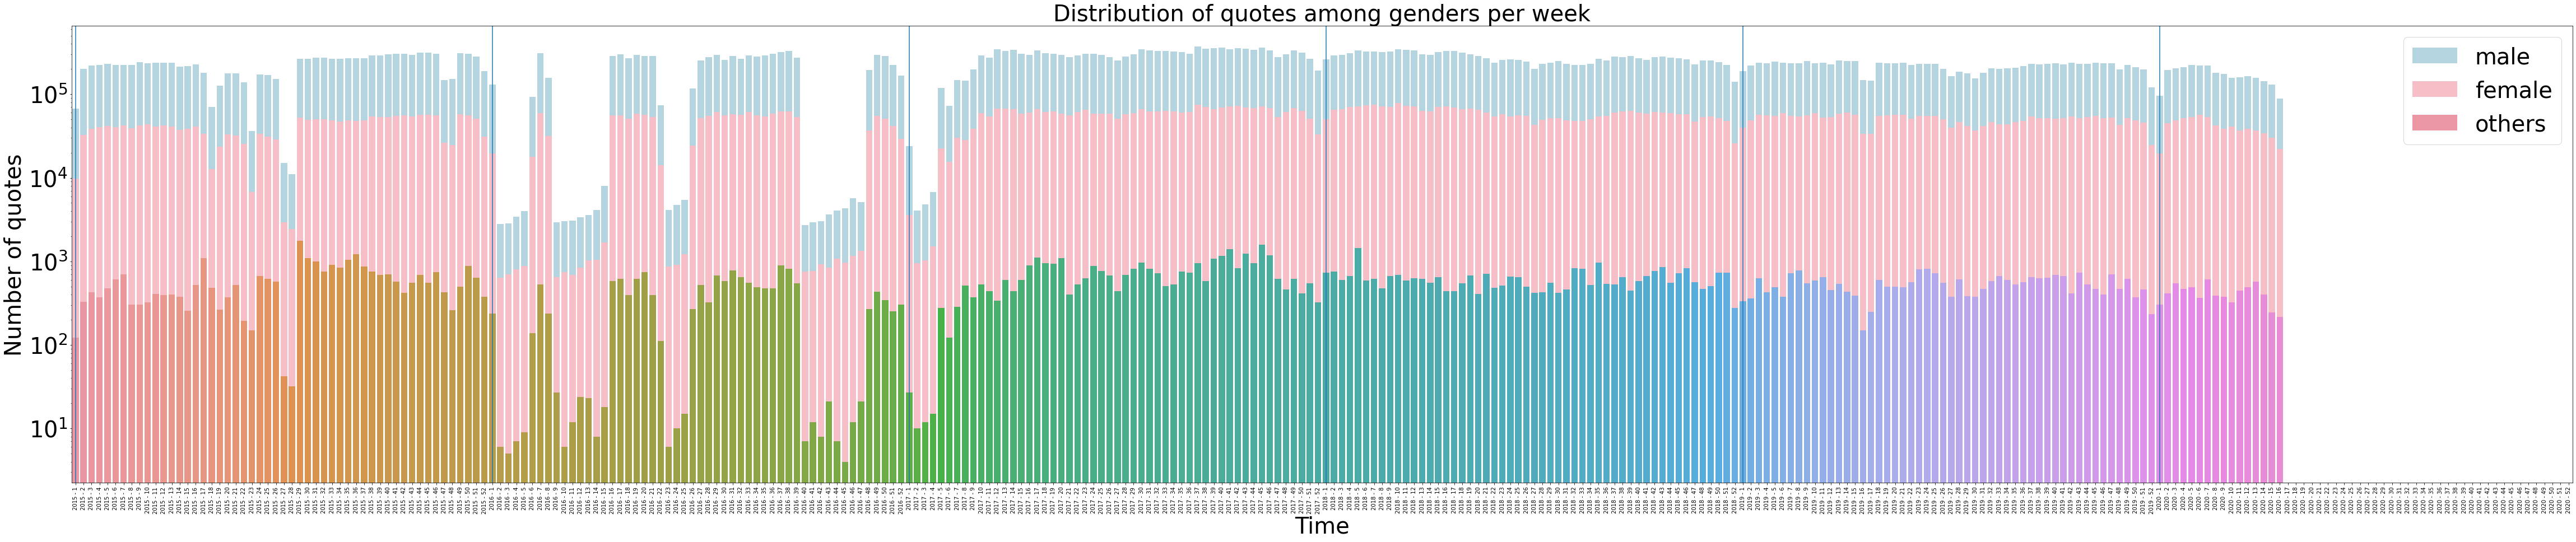

In [11]:
# Weekly count for entier Quotebank
helper.plot_count_log_scale(plot_df_list[0])

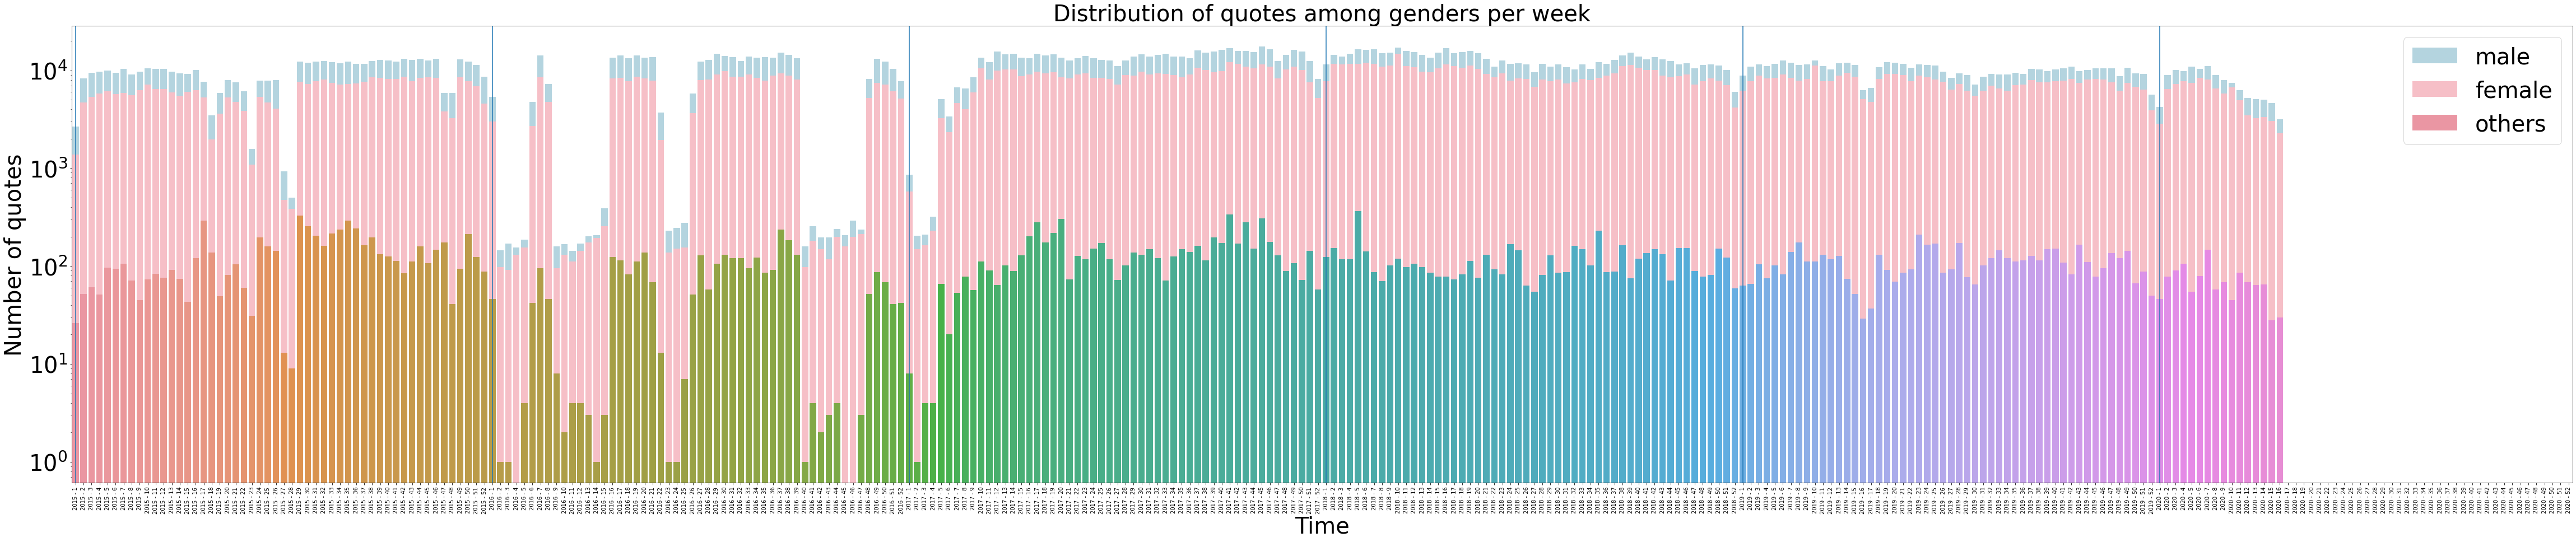

In [12]:
# Weekly count for D2 (women)
helper.plot_count_log_scale(plot_df_list[1])

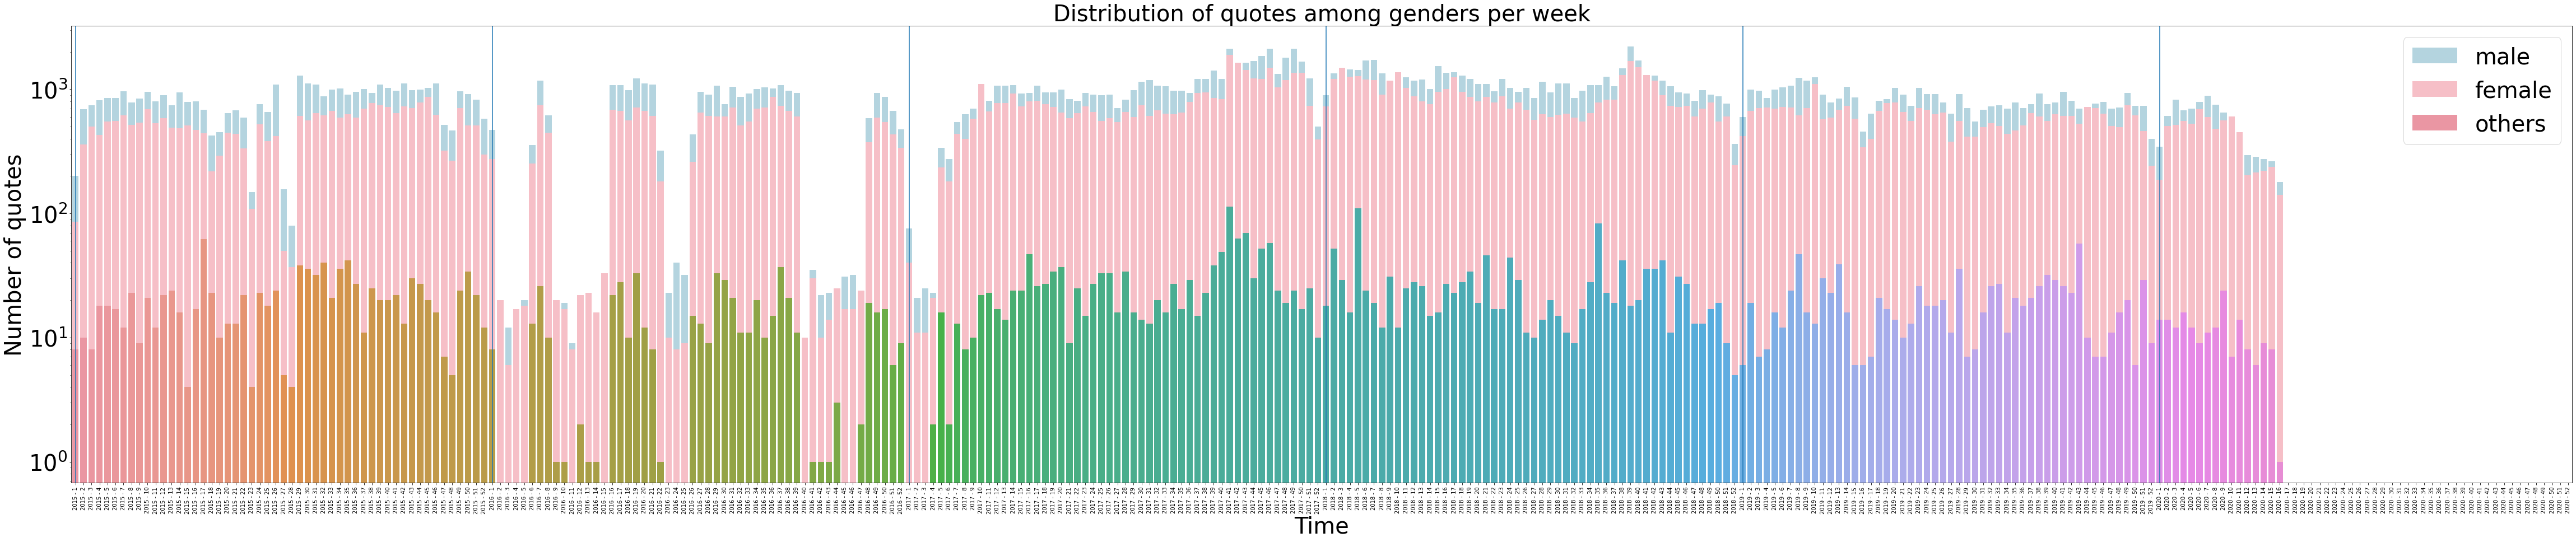

In [13]:
# Weekly count for D1 (metoo)
helper.plot_count_log_scale(plot_df_list[2])

### B) <u> Gender weekly percentage on Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset (D1) </u> <a id="Step-2-B"> </a>

We plot here the weekly percentage of quotes by author’s gender (men, women) from 2015 to 2020. This will allow us to have a general perspective on the place that women are being given in the mediatic place through time.
With our result, we would like to observe if the place given to woman, in terms of weekly percentage of speaker, correlates with the #MeToo movement important dates.

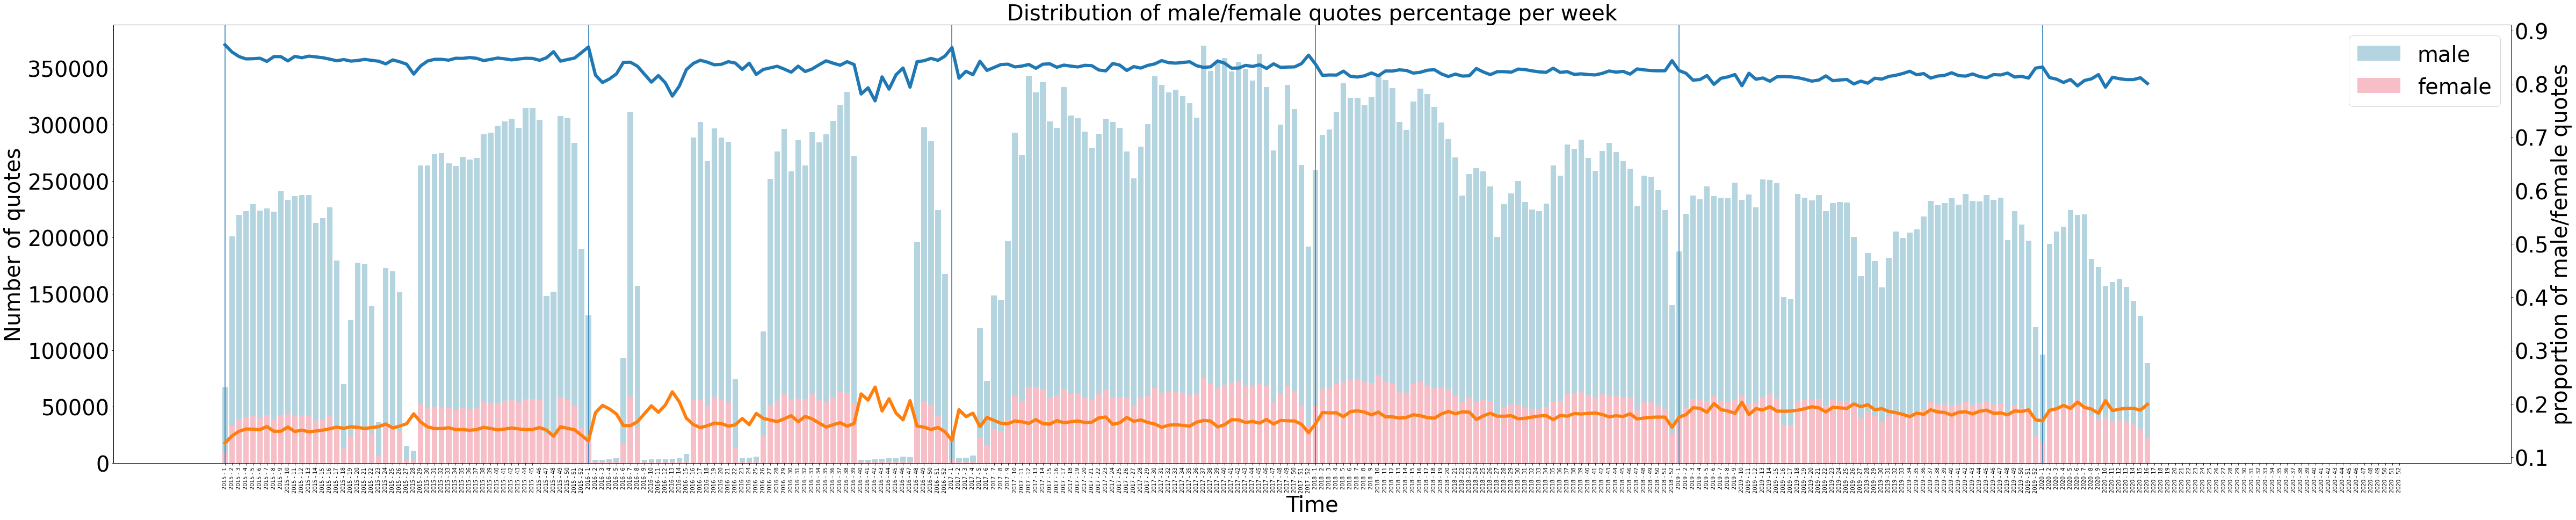

In [14]:
# Weekly count and percentage for D2 (women)
helper.plot_count_lin_scale(plot_df_list[0])

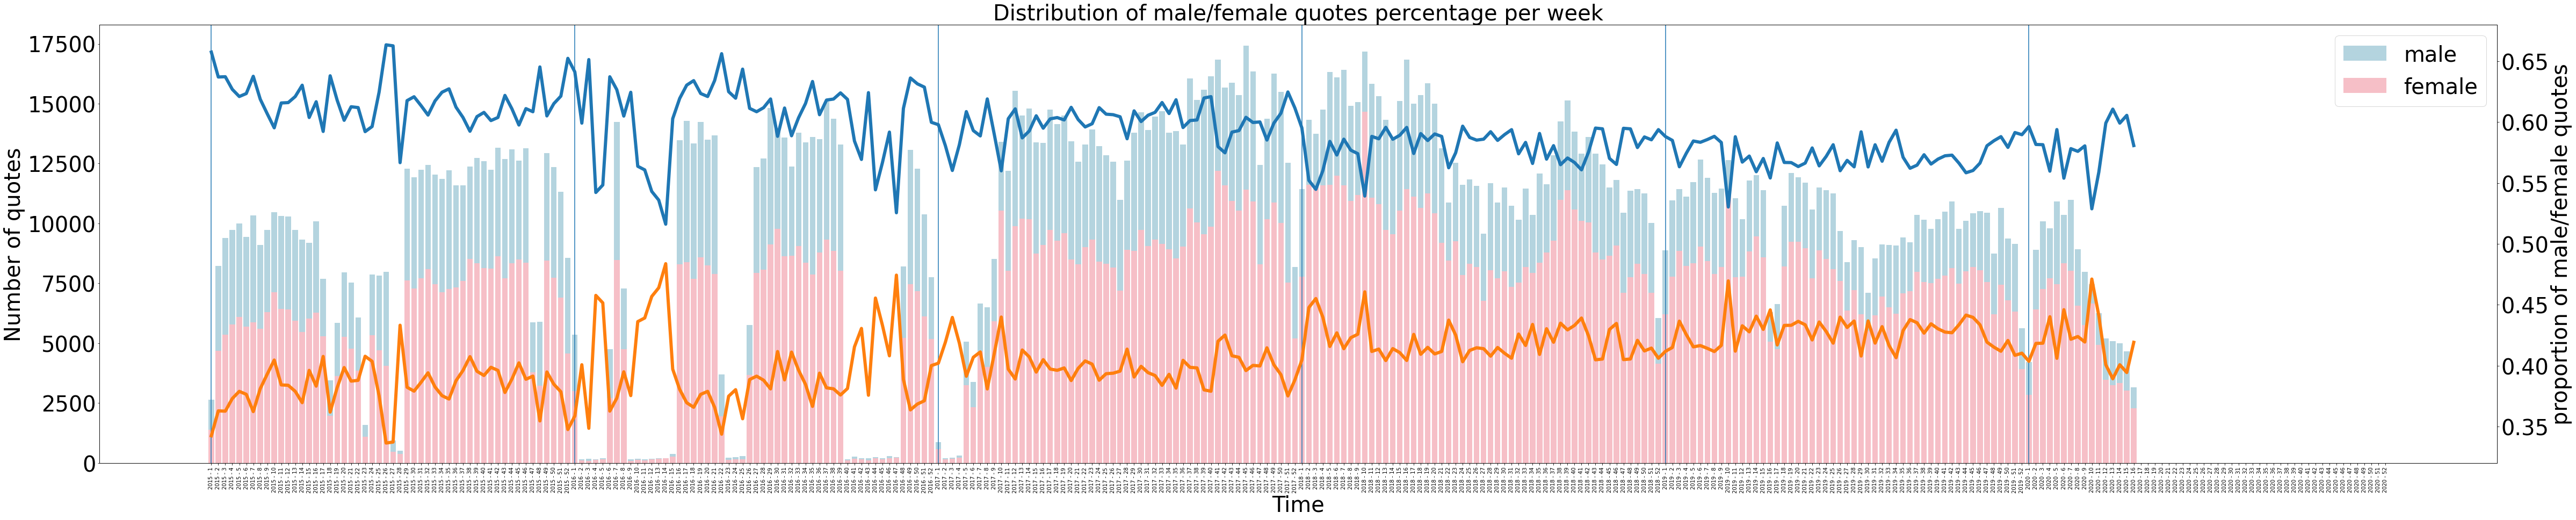

In [15]:
# Weekly count and percentage for D1 (metoo)
helper.plot_count_lin_scale(plot_df_list[1])

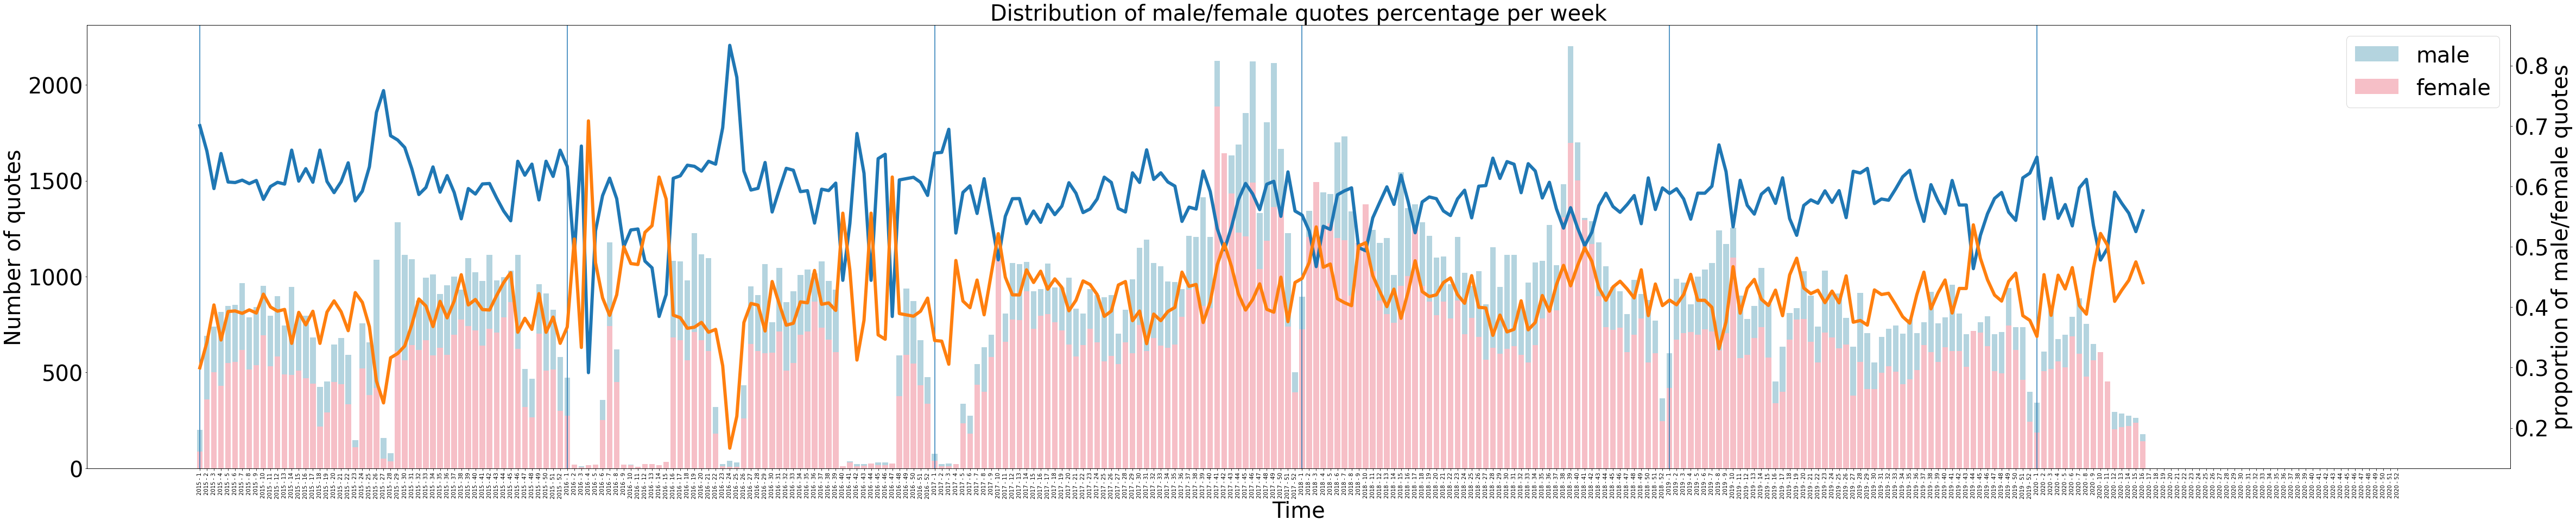

In [16]:
# Weekly count MeToo
helper.plot_count_lin_scale(plot_df_list[2])

---
## **Step 3:  Generate annual and monthly word clouds based on general women coverage dataset (D2)** <a id="Step-3"> </a>

For the sake of readibility of the notebook, cell outputs have been cleared in this section. Still, the associated generated wordclouds can be found in the `./results/Wordclouds` folder of the repository. Some wordclouds will be shown in this notebook to get only some insights of what have been done.

***Initialization***

In [ ]:
# Initialization cell for all later generated wordclouds
CHUNK_SIZE = 250
YEAR_QUOTES_FOLDER = PATH_DATA + f'{year}/' 
RESULTS_FOLDER = "./results/Wordclouds/"

figure(figsize=(12, 10))
# Read the mask image for the wordcloud 
women_mask = np.array(Image.open(r"./data/women_symbol_mask.png"))

In [ ]:
# Initilalize spacy analyzer in english
nlp = spacy.load('en')

***Stopwords dataset construction***

In [ ]:
# Stopwords removal 
PATH_STOPWORD = PATH_DATA + 'stopword_list.csv'
sw = pd.read_csv(PATH_STOPWORD, header=None)
sw_list = list(sw.values.flatten())
sw_list =  sw_list[:-2] #remove 2 NaNs at the end of the list

# Wordcloud library stopwords
stopwords =  list(STOPWORDS) + sw_list

# Additionnal handpicked stopwords
add_sw = handpicked_stopwords()
stopwords = stopwords + add_sw

# Adding default spacy stopword list
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords = stopwords + list(spacy_stopwords)

nlp.Defaults.stop_words = stopwords

For all sub-sections below and their respective wordclouds, the same NLP pipeline has been used chunk by chunk. First, we construct a long string with all quotes ofthe cunk appended inside. We proceed to casefolding in order to have all words in lower case. Then, we remove all words strictly shorter than 3 letters to filter weird quotes retranscription where words are cut or to filter very short words that might be not present in our stopword list. Later, we tokenize and lemmatize vthanks to Spacy tokenizer and lemmatizer. At the same time, we remove stopwords from our stopwords list but also punctuation, pronouns and the character ` from our whole text list. 

Each string generated for each chunk are appended into the same final string before being passed to the WordCloud function of the wordcloud library to generate the appropriate wordcloud. We also pass as a parameter the women symbol mask and the stopwords list as matter of security to be sure the stopwords are well removed. Some parameters needed to be tuned by test and trials, namely max_words, max_font_size, random_state, height, width and collocation_threshold. After several trials, the final collocation threshold for the accounting of bigrams in the wordcloud generation was set to 5.

### A.  <u>  Running a word cloud per month on general women coverage dataset (D2)</u> <a id="Step-3-A"> </a>


We generate a wordcloud for each month of each year of the general women coverage dataset (D2). 

The generated wordclouds can be found in the `./results/Wordclouds/2015`, `./results/Wordclouds/2016`, `./results/Wordclouds/2017`, `./results/Wordclouds/2018`, `./results/Wordclouds/2019` and `./results/Wordclouds/2020` folder of the repository. The generated wordclouds are all named according to the following format: `{year}_{month_number}_tresh5.png`.

In [ ]:
for month in ('01','02','03','04','05','06','07','08','09','10','11','12'):
    
    MONTH_QUOTES_FILE = YEAR_QUOTES_FOLDER + f'{year}_' + f'{month}.json.bz2'
    RESULTS_FOLDER = YEAR_QUOTES_FOLDER + 'Wordclouds/'
    reader = pd.read_json(MONTH_QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE, typ='frame')
    
    print(f'month {month} start\n')

    j = 0
    words = []
    for chunk in reader:

        # Convert into single string text
        text = ""
        text = ' '.join(quote for quote in chunk.quotation)
        # Casefolding
        text = text.lower()
        # Remove words shorter than 3 characters
        new_text = ' '.join([w for w in text.split() if len(w)>2])   
       
        # Creating a spacy object
        doc = nlp(new_text)
        # Tokenizer
        tokens = [token.text for token in doc]
        # Lemmatization
        # removing stop words and lematize
        words = words + [token.lemma_ for token in doc if (str(token) in stopwords) != True and token.is_punct != True 
                    and str(token) != '-PRON-' and str(token) != '`']
                    
        print(f'{j+1} chunk')
        j = j+1

    print(f'month {month} done \n')
    
    text_wordcloud = ""
    text_wordcloud = ' '.join(word for word in words)
    
    print(f'month {month} wordcloud processing \n')
    
    # Generate Wordcloud
    wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
               stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud)

    # Store to file
    wc.to_file(path.join(RESULTS_FOLDER, f"{year}_"+f"{month}_thresh5.png"))

    print(f'month {month} wordcloud figure saved \n')

***Output examples:*** Wordclouds for January 2015, August 2016, October 2017, March 2018, May 2019 and February 2020.

![image info](results/Wordclouds/2015/2015_01_thresh5_v2.png) ![image info](results/Wordclouds/2016/2016_08_thresh5_v2.png)
![image info](results/Wordclouds/2017/2017_10_thresh5_v2.png) ![image info](results/Wordclouds/2018/2018_05_thresh5_v2.png)
![image info](results/Wordclouds/2020/2020_02_thresh5_v2.png)

We can observe that words related to MeToo movement denunciations of the oppressing environement women are subject to, are shown with more importance in the month wordclouds at the end of 2017 and at the beginning of 2018 when they were either not present or shown with less important in the Pre MeToo wordcloud. To observe this, look for example for the following words: "domestic abuse", "domestic violence", "sexual abuse", "sexual violence", "sexual harassment", "harvey weinstein", "sexually harass".

**Note:** In general, the number of chunks for each month are of the same order of magnitude (400-600). However, only the month of January, March, June, October and November, 2016 and January 2017 contain a very small number of chunks (around 10-20). Thus, the wordclouds generated for these specific months cannot be used for qualitative analysis of the words used to talk about women, as this induces a bias. Indeed, as the number of quotes is way lower, the occurencies of very specific words become more important with respect to the more general words used to talk about women and mainly present in the other wordclouds which have lower occurencies then usually. For instance, the words usually present in all wordclouds, "man", "family", "love" are not showed with the same importance or not shown at all.

***Example:*** March 2016 which consists of 9 chunks only.

![image info](results/Wordclouds/2016/2016_03_thresh5_v2.png)

### B. <u> Running a word cloud for period before MeToo and period after MeToo on general women coverage dataset (D2)</u> <a id="Metoowordcloud"></a> <a id="Step-3-B"> </a>

We generate a wordcloud for the period before the MeToo movement and another one for the period after the MeToo movement based on the general women coverage dataset (D2). 

The generated wordclouds can be found in the `./results/Wordclouds/` folder of the repository. The generated wordclouds are all named according to the following format: `Post_MeToo_wordcloud.png` and `Pre_MeToo_wordcloud.png`.

***Pre-MeToo word cloud generation***

The period taken into account for the Pre-MeToo period starts in January, 2015 and ends in September, 2017, included.

In [ ]:
text_wordcloud_general = ""

for year in (2015, 2016, 2017):
    
    YEAR_QUOTES_FOLDER = PATH_DATA + f'{year}/' 
    
    if(year == 2017):
        month_list = ('01','02','03','04','05','06','07','08','09')
    else : month_list = ('01','02','03','04','05','06','07','08','09','10','11','12')
    
    text_wordcloud_year = ""

    for month in month_list:
    
        MONTH_QUOTES_FILE = YEAR_QUOTES_FOLDER + f'{year}_' + f'{month}.json.bz2'
        RESULTS_FOLDER = YEAR_QUOTES_FOLDER + 'Wordclouds/'
        reader = pd.read_json(MONTH_QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE, typ='frame')
    
        print(f'month {month} start\n')

        j = 0
        words = []
        for chunk in reader:

            # Convert into single string text
            text = ""
            text = ' '.join(quote for quote in chunk.quotation)
            # Casefolding
            text = text.lower()
            # Remove words shorter than 3 characters
            new_text = ' '.join([w for w in text.split() if len(w)>2])   
       
            # Creating a spacy object
            doc = nlp(new_text)
            # Tokenizer
            tokens = [token.text for token in doc]
            # Lemmatization
            # removing stop words and lematize
            words = words + [token.lemma_ for token in doc if (str(token) in stopwords) != True and token.is_punct != True 
                    and str(token) != '-PRON-' and str(token) != '`']
                    
            print(f'{j+1} chunk')
            j = j+1

        print(f'month {month} done \n')
    
        text_wordcloud_year = ' '.join(word for word in words)
        text_wordcloud_general = ' '.join(word for word in words)
    
        print(f'month {month} added\n')
    
    print(f'Year {year} wordcloud processing \n')
    # Generate Wordcloud
    wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
                    stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud_year)

    # Store to file
    wc.to_file(path.join(RESULTS_FOLDER, f"{year}_"+"wordcloud.png"))

    print(f'year {year} wordcloud figure saved \n')

print(f'General pre-MeToo wordcloud processing \n')
# Generate Wordcloud
wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
                    stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud_general)

# store to file
wc.to_file(path.join(PATH_DATA, "Pre_MeToo_wordcloud.png"))

print('General pre-MeToo wordcloud figure saved \n')


***Post-MeToo word cloud generation***

The period taken into account for the Pre-MeToo period starts in October, 2017 and ends in April, 2020, included.

In [ ]:
text_wordcloud_general = ""

for year in (2017, 2018, 2019, 2020):
    
    YEAR_QUOTES_FOLDER = PATH_DATA + f'{year}/' 
    
    if(year == 2020):
        month_list = ('01','02','03','04')
    else: 
        if(year == 2017):
            month_list = ('10','11','12')
        
        else : 
            month_list = ('01','02','03','04','05','06','07','08','09','10','11','12')
    
    text_wordcloud_year = ""

    for month in month_list:
    
        MONTH_QUOTES_FILE = YEAR_QUOTES_FOLDER + f'{year}_' + f'{month}.json.bz2'
        RESULTS_FOLDER = YEAR_QUOTES_FOLDER + 'Wordclouds/'
        reader = pd.read_json(MONTH_QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE, typ='frame')
    
        print(f'month {month} start\n')

        j = 0
        words = []
        for chunk in reader:

            # Convert into single string text
            text = ""
            text = ' '.join(quote for quote in chunk.quotation)
            # Casefolding
            text = text.lower()
            # Remove words shorter than 3 characters
            new_text = ' '.join([w for w in text.split() if len(w)>2])   
       
            # Creating a spacy object
            doc = nlp(new_text)
            # Tokenizer
            tokens = [token.text for token in doc]
            # Lemmatization
            # removing stop words and lematize
            words = words + [token.lemma_ for token in doc if (str(token) in stopwords) != True and token.is_punct != True 
                    and str(token) != '-PRON-' and str(token) != '`']
                    
            print(f'{j+1} chunk')
            j = j+1

        print(f'month {month} done \n')
    
        text_wordcloud_year = ' '.join(word for word in words)
        text_wordcloud_general = ' '.join(word for word in words)
    
        print(f'month {month} added\n')
    
    print(f'Year {year} wordcloud processing \n')
    # Generate Wordcloud
    wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
                    stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud_year)

    # store to file
    wc.to_file(path.join(RESULTS_FOLDER, f"{year}_"+"wordcloud.png"))

    print(f'year {year} wordcloud figure saved \n')

print(f'General pre-MeToo wordcloud processing \n')
# Generate Wordcloud
wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
                    stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud_general)

# store to file
wc.to_file(path.join(PATH_DATA, "Post_MeToo_wordcloud.png"))

print('General post-MeToo wordcloud figure saved \n')


***Outputs:*** Wordclouds Pre-MeToo and Post-MeToo

![image info](results/Wordclouds/Pre_MeToo_wordcloud.png) ![image info](results/Wordclouds/Post_MeToo_wordcloud.png)

We can observe that words related to MeToo movement denunciations of the oppressing environement women are subject to, are shown with more importance in the Post MeToo wordcloud when they were either not present or shown with less important in the Pre MeToo wordcloud. To observe this, look for the following words: "domestic abuse", "domestic violence", "sexual abuse", "sexual violence".

### C. <u>Running a wordcloud for each year on general women coverage dataset (D2)</u><a id="Step-3-C"> </a> 

As the wordclouds for the years 2015, 2016, 2018, 2019 and 2020 were directly generated during section C [above](#Metoowordcloud), the only wordcloud missing is the one of year 2017, which was not processed before as the begining of MeToo mediatization started in october 2017. We now generate the wordcloud for the year 2017 of the D2 dataset mentionning women in quotes.

The generated wordclouds can be found in the `./results/Wordclouds/2015`, `./results/Wordclouds/2016`, `./results/Wordclouds/2017`, `./results/Wordclouds/2018`, `./results/Wordclouds/2019` and `./results/Wordclouds/2020` folder of the repository. The generated wordclouds are all named according to the following format: `{year}_wordcloud.png`.

In [ ]:
year=2017

YEAR_QUOTES_FOLDER = PATH_DATA + f'{year}/' 

month_list = ('01','02','03','04','05','06','07','08','09','10','11','12')

text_wordcloud_year = ""

for month in month_list:

    MONTH_QUOTES_FILE = YEAR_QUOTES_FOLDER + f'{year}_' + f'{month}.json.bz2'
    RESULTS_FOLDER = YEAR_QUOTES_FOLDER + 'Wordclouds/'
    reader = pd.read_json(MONTH_QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE, typ='frame')

    print(f'month {month} start\n')
    j = 0
    words = []
    for chunk in reader:
        # Convert into single string text
        text = ""
        text = ' '.join(quote for quote in chunk.quotation)
        # Casefolding
        text = text.lower()
        # Remove words shorter than 3 characters
        new_text = ' '.join([w for w in text.split() if len(w)>2])   
   
        # Creating a spacy object
        doc = nlp(new_text)
        # Tokenizer
        tokens = [token.text for token in doc]
        # Lemmatization
        # removing stop words and lematize
        words = words + [token.lemma_ for token in doc if (str(token) in stopwords) != True and token.is_punct != True 
                and str(token) != '-PRON-' and str(token) != '`']
                
        print(f'{j+1} chunk')
        j = j+1

    print(f'month {month} done \n')
    
    text_wordcloud_year = ' '.join(word for word in words)
    
    print(f'month {month} added\n')
    
print(f'Year {year} wordcloud processing \n')
# Generate Wordcloud
wc = WordCloud(color_func=violet_color_func, background_color="white", max_words=2000, mask=women_mask,
                stopwords=stopwords, max_font_size=40, random_state=1,height=100,width=100,collocation_threshold=5).generate(text_wordcloud_year)

# store to file
wc.to_file(path.join(RESULTS_FOLDER, f"{year}_"+"wordcloud.png"))

print(f'year {year} wordcloud figure saved \n')


***Outputs:*** Wordclouds for 2015, 2016, 2017, 2018, 2019 and 2020.

![image info](results/Wordclouds/2015/2015_wordcloud.png) ![image info](results/Wordclouds/2016/2016_wordcloud.png)
![image info](results/Wordclouds/2017/2017_wordcloud.png) ![image info](results/Wordclouds/2018/2018_wordcloud.png)
![image info](results/Wordclouds/2019/2019_wordcloud.png) ![image info](results/Wordclouds/2020/2020_wordcloud.png)

When looking at those year wordclouds, we remark instantaneously that the year 2017 is different. The more generic words such as "man","wife", "home", "love", "family", etc are given much less importance than in the previous and later years. We can observe that words related to MeToo movement are shown with more importance in 2017 and propagate in 2018, 2019 and 2020 but wth less importance. To observe this, look for the following words: "domestic abuse", "domestic violence", "sexual abuse", "sexual violence", "harvey weinstein", "bill cosby", "roy moore", etc.

---
## **Step 4:  Investigate general women perception via general women coverage in medias (D2)** <a id="Step-4"> </a>

### A. <u>Sklearn model training on AD2 for classifying the quotes as misogynistic or non misogynistic</u><a id="Step-4-A"> </a> 

In this step, a linear classifier is trained on the reddit dataset. It classifies quotes as mysoginistic or non mysoginistic.

In [ ]:
PATH_DATA = './data/data_nlp/'
AD1_FILE = PATH_DATA + 'original_labels.csv'
CHUNK_SIZE = 1000

df = pd.read_csv(AD1_FILE)
df.head(3)

,entry_id,link_id,parent_id,entry_utc,subreddit,author,body,image,label_date,week,group,sheet_order,annotator_id,level_1,level_2,level_3,strength,highlight
0,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",3,Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN
1,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",6,Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN
2,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",4,Misogynistic,Derogation,Sexual_or_physical_limitations,Nature of the abuse is Implicit,"skin of a 80 year old grandma? Worry no more, ..."


In [ ]:
df.drop(columns=['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author',
       'label_date', 'week', 'group', 'sheet_order',
       'annotator_id', 'level_2', 'level_3', 'strength',
       'highlight'], inplace=True)

In [ ]:
one_hot = pd.get_dummies(df['level_1'])
df['misogynistic'] = one_hot.Misogynistic.values

In [ ]:
df = df[~df['image'].isin(['Yes'])]
df.drop(['image', 'level_1'], axis=1, inplace=True)
df.dropna(inplace=True)
df = df[~df['body'].isin(['[removed]'])]

In [ ]:
nlp = spacy.load('en_core_web_sm')
punct = string.punctuation

In [ ]:
def remove_url(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r"", text)

def text_data_cleaning(sentence):
    sentence = remove_url(sentence)
    sentence = remove_html(sentence)
    sentence = remove_emoji(sentence)
    doc = nlp(sentence)

    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in nlp.Defaults.stop_words and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

***Training Pipeline***

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning, ngram_range=(1,2))
classifier = LinearSVC()

In [ ]:
X = df.body
y = df.misogynistic

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [ ]:
X_train.shape, X_test.shape

((12160,), (3040,))

In [ ]:
X_train[1231]

'Bernie is a commie jew....no wonder the sheep masses love him.\n\nI wonder why the system hates him so much...probably because it\'d be too transparent and people , white people, may start to wake up to our genocide if someone who is openly jewish and anti white was elected...\n\nRemember, they are "white" just like us , goyim'

In [ ]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function text_data_cleaning at 0x7fe9db22c9d0>)),
                ('clf', LinearSVC())])

In [ ]:
y_pred = clf.predict(X_test)

***Training results:***

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2709
           1       0.72      0.58      0.65       331

    accuracy                           0.93      3040
   macro avg       0.84      0.78      0.80      3040
weighted avg       0.93      0.93      0.93      3040



In [ ]:
confusion_matrix(y_test, y_pred)

array([[2635,   74],
       [ 138,  193]])

In [ ]:
import pickle
filename = './data/data_nlp/classifier2.sav'
pickle.dump(clf, open(filename, 'wb'))

### B. <u> Predictions of misogynistic or non-misogynistic quotes on general women coverage in medias (D2)</u><a id="Step-4-B"> </a> 

We then predicted, thanks to our trained model, misogynistic quotes on the general women coverage (D2) on several years. In a matter of readability, we present here only the output for the year 2019.

In [ ]:
import pickle
clf = pickle.load(open('./data/data_nlp/classifier2.sav', 'rb'))

In [ ]:
year = 2019 # available: from 2015 to 2020
PATH_DATA = './data/data_nlp/predict/'
QUOTES_FILE = PATH_DATA + f'{year}_male.json.bz2'

df = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', typ='frame')


In [ ]:
df['Mysoginistic'] = df.quotation.apply(lambda quote: clf.predict([quote]))

In [ ]:
men_mysoginistic = df[df.Mysoginistic==1]
men_mysoginistic.shape

(56, 12)

In [ ]:
for i, quote in enumerate(men_mysoginistic.quotation):
    print(f'{men_mysoginistic.iloc[i].speaker}: "{quote}"')

Jon Ronson: "Somebody HIV + should rape this bitch."
Mel Gibson: "You look like a f *** ing bitch in heat. And if you get raped by a pack of n **** s it will be your fault. Alright? Because you provoked it. You are provocatively dressed all the time with your fake boobs that you feel you have to show off. I don't like it. I don't want that woman. I don't want you. I don't trust you. I don't love you."
Stanley Ntagali: "We condemn in the strongest term possible, actions of rape and violence against women and girls. As a church, we are deeply concerned about the increasing trend of sexual and gender-based violence in the country especially towards women and girls including the continued harmful practices such as Female Genital Mutilation and child marriages. I am also concerned about the increasing cases of child molesting and defilement and its negative consequences."
Ty Dolla $ ign: "Got too many hoes, I just leave 'em on read / Too much sex, shawty, you can give me head,"
ansel elgort

***Comment:***
As you can observe, a lot of extremely mysoginistic quote have been detected by the classifier. 
However, there is a large amount of false positives and false negatives. It can therefore not be used for accurate classification but it can be used to quickly find examples of mysoginistic quotes in the datasets. However, we didn't find our classifier robust enough in order to make further analysis of the evolution of the proportion of misogynistic quotes through time.

### C. <u> Topic extraction on general women coverage in medias (D2)</u><a id="Step-4-C"> </a> 

In this part, we conduct a topic extraction on the year 2017 to see wich topic were discussed during this year. 

In [ ]:
import spacy, nltk, gensim, sklearn
import pandas as pd
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases


In [ ]:
def create_corpus(quotes):
    #Putting all the quotes in one corpus
    text = ""

    for quote in quotes:
        text = text + ' ' + quote

    #Removing the new lines
    text = " ".join(text.split())
    return text


In [ ]:
year = 2017 # available: from 2015 to 2020
PATH_DATA = './data/data_nlp/'
QUOTES_FILE = PATH_DATA + f'quotes-{year}-filtered.json.bz2'
CHUNK_SIZE = 250

reader = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE, typ='frame')

chunks = [] #utile pour plus loins quand on fait le feature extraction

for i, chunk in enumerate(reader):
    chunks.append(create_corpus(chunk.quotation))

print(len(chunks))

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
PATH = PATH_DATA + 'stopword_list.csv'
sw = pd.read_csv(PATH, header=None)
sw


,0,1,2,3,4
0,a's,able,about,above,according
1,accordingly,across,actually,after,afterwards
2,again,against,ain't,all,allow
3,allows,almost,alone,along,already
4,also,although,always,am,among
...,...,...,...,...,...
104,why,will,willing,wish,with
105,within,without,won't,wonder,would
106,wouldn't,yes,yet,you,you'd
107,you'll,you're,you've,your,yours


In [ ]:
#loading default spacy stopword list
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
len(spacy_stopwords)

#creating new stopword list
sw_list = list(sw[0]) + list(sw[1]) + list(sw[2]) + list(sw[3]) + list(sw[4]) + list(spacy_stopwords)
nlp.Defaults.stop_words = sw_list


#creating a spacy object
sw_list


In [ ]:
processed_docs = list()
for doc in nlp.pipe(chunks, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in sw_list and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs


In [ ]:
save = copy.deepcopy(processed_docs)

In [ ]:
# Add bigrams too
# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(save, min_count=15)

for idx in range(len(save)):
    for token in bigram[save[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            save[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
dictionary = Dictionary(save)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 1
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in save]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 100000
Number of chunks: 751


In [ ]:
# models
from gensim.models import LdaMulticore
from numpy.random import seed as random_seed

seed = 32
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary,
                passes=params['passes'], random_state=params['random_state'])

In [ ]:
# plot topics
import pyLDAvis.gensim_models
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

---
## **Step 5-6:  Investigate gender and generational biases in general women coverage  (D2 - Step 5) and in MeToo coverage (D1 - Step 6) using NLP** <a id="Step-5-6"> </a> 

### A. <u>Sentiment analysis on D1 and D2 - Subdivision into sets D1.2 and D2.2, per age categories </u><a id="Step-5-6-A"> </a> 

Here, we compute the quotes' compunds with the `nltk` library, in order to investigate the influence of the #MeToo movement.

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
age_limite1 = 40
age_limite2 = 60
compound_limite = 0.05

data_paths = [PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
for path in data_paths:
    for year in YEARS:
        helper.create_compounds(sia, path, year, age_limite1, age_limite2, compound_limite, quote_column, df_selected_parquet)

### B. <u>Sentiment analysis on D1 and D2 - Computation of the mean compound per gender </u><a id="Step-5-6-B"> </a>  

We split each gender's quotes into three categories according to speaker's age: \[0,40\], \[41,60\] and \[60,+inf\] and compute the mean compound per groups.\
We also compute mean of compound per sentient categories for each age categories. The sentiments categories are classified in term of comound value: *negatif* : \[-1, -.0.05\]; *neutral* : ]-0.05, 0.05\[ and *positif* : \[0.05, 1\]

In [ ]:
data_paths = [PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
for path in data_paths:
    for year in YEARS:
        helper.create_mean_compounds_per_gender_age(path, year, qid_male, qid_female)

***Gender - Age***

In [48]:
# Read result from previous cell
comp_women = []
for year in YEARS_CMP:
    data_path = PATH_QUOTE_WOMEN.format(year)
    path = data_path[:-9] + '_sentiment_age_compounds_per_gender_age' + data_path[-9:]
    comp_women.append(pd.read_json(path, lines=True).set_index(['gender', 'age_cat']))

In [26]:
# 2015
comp_women[0]

count       std      mean
gender age_cat                            
female 0_40     122494  0.511388  0.272702
       41_60     98124  0.519189  0.197852
       61_inf    59360  0.507466  0.167490
male   0_40     118746  0.512369  0.221326
       41_60    177844  0.519858  0.185124
       61_inf   152153  0.520108  0.158883

In [27]:
# 2017
comp_women[1]

std   count      mean
gender age_cat                            
female 0_40     0.517734  166705  0.265151
       41_60    0.527358  134543  0.182799
       61_inf   0.513748   81169  0.166448
male   0_40     0.521892  149693  0.222894
       41_60    0.525520  220183  0.190315
       61_inf   0.526987  203856  0.160247

In [28]:
# 2019
comp_women[2]

std   count      mean
gender age_cat                            
female 0_40     0.520441  155611  0.282933
       41_60    0.526895  127909  0.204244
       61_inf   0.515555   77663  0.175977
male   0_40     0.529303  115733  0.224489
       41_60    0.534557  183742  0.186918
       61_inf   0.532132  178425  0.151518

***Sentiment - Age - Gender***

In [11]:
comp_metoo = []
for year in YEARS_CMP:
    data_path = PATH_QUOTE_WOMEN.format(year)
    path = data_path[:-9] + '_sentiment_age_compounds_per_gender_age_sentiment' + data_path[-9:]
    comp_metoo.append(pd.read_json(path, lines=True).set_index(['sentiment','age_cat','gender']))

In [51]:
# 2015
comp_metoo[0]

count       std      mean
sentiment age_cat gender                           
neg       0_40    female  26415  0.248069 -0.480850
                  male    28312  0.249431 -0.489914
          41_60   female  25100  0.251812 -0.500344
                  male    46955  0.252674 -0.500813
          61_inf  female  15519  0.249649 -0.499145
                  male    42081  0.253973 -0.506974
neu       0_40    female  22387  0.007569  0.000171
                  male    24129  0.006994  0.000144
          41_60   female  19301  0.007412  0.000243
                  male    35371  0.007471  0.000196
          61_inf  female  13312  0.007156  0.000004
                  male    32158  0.007206  0.000159
pos       0_40    female  73692  0.248931  0.625606
                  male    66305  0.249383  0.605513
          41_60   female  53723  0.251244  0.595052
                  male    95518  0.251516  0.590798
          61_inf  female  30529  0.247379  0.579396
                  male    77914  0.250637  0.584020

In [52]:
# 2017
comp_metoo[1]

std   count      mean
sentiment age_cat gender                            
neg       0_40    female  0.250312   37128 -0.488231
                  male    0.250740   36535 -0.497534
          41_60   female  0.252281   36015 -0.511478
                  male    0.252369   58190 -0.506263
          61_inf  female  0.250008   21593 -0.504158
                  male    0.252853   56914 -0.515307
neu       0_40    female  0.007602   29860  0.000166
                  male    0.007162   29091  0.000030
          41_60   female  0.007395   26319  0.000105
                  male    0.007623   42538  0.000221
          61_inf  female  0.007193   17792  0.000286
                  male    0.007287   41490  0.000161
pos       0_40    female  0.250869   99717  0.625009
                  male    0.250251   84067  0.613109
          41_60   female  0.251822   72209  0.595665
                  male    0.251228  119455  0.597331
          61_inf  female  0.249243   41784  0.583755
                  male    0.251212  105452  0.587840

In [53]:
# 2019
comp_metoo[2]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.251882  33699 -0.490264
                  male    0.253055  28748 -0.502650
          41_60   female  0.254239  32968 -0.504139
                  male    0.254216  49950 -0.513559
          61_inf  female  0.250866  20378 -0.502675
                  male    0.254207  51805 -0.515771
neu       0_40    female  0.007877  26436  0.000226
                  male    0.007727  21394  0.000171
          41_60   female  0.007435  24284  0.000210
                  male    0.007675  34165  0.000221
          61_inf  female  0.007180  16722  0.000332
                  male    0.007516  35415  0.000257
pos       0_40    female  0.250130  95476  0.634117
                  male    0.254023  65591  0.616355
          41_60   female  0.251838  70657  0.604895
                  male    0.253404  99627  0.602141
          61_inf  female  0.249627  40563  0.589326
                  male    0.252539  91205  0.589277

#### ***Compounds for specific Date (women's day and #MeToo tweet)***
In order to highlight #MeToo movment influence even more, we also compute compounds of each previously mentioned group for two particular date: #MeToo tweet (15 oct.) and Women's Day (03 mars) of each year.

In [30]:
dates=[(8,3),   # Women's Day
       (15,10)] # #MeToo tweet

In [ ]:
data_paths = [PATH_QUOTE_WOMEN, PATH_QUOTE_METOO]
for path in data_paths:
    for year in YEARS:
        for date in dates:
            helper.create_mean_compound_at_date()

***Gender - Age***

In [36]:
# Read result from previous cell
comp_women_date = [[],[]]
for i, date in enumerate(dates):
    for year in YEARS_CMP:
        data_path = PATH_QUOTE_WOMEN.format(year)
        path = data_path[:-9] + '_sentiment_age_compounds_per_gender_age_{}_{}'.format(date[0], date[1]) + data_path[-9:]
        comp_women_date[i].append(pd.read_json(path, lines=True).set_index(['gender', 'age_cat']))

In [38]:
# Women's Day, 2015
comp_women_date[0][0]

std  count      mean
gender age_cat                           
female 0_40     0.508436   1550  0.247813
       41_60    0.528299   1446  0.174091
       61_inf   0.513701    904  0.146341
male   0_40     0.501313   1399  0.220921
       41_60    0.517701   2277  0.169012
       61_inf   0.504035   1838  0.180751

In [39]:
# Women's Day, 2017
comp_women_date[0][1]

std  count      mean
gender age_cat                           
female 0_40     0.520402   2964  0.237402
       41_60    0.519784   2231  0.206869
       61_inf   0.509623   1470  0.191106
male   0_40     0.513961   2011  0.252311
       41_60    0.522862   3129  0.224445
       61_inf   0.525816   3091  0.171917

In [41]:
# Women's Day, 2019
comp_women_date[0][2]

std  count      mean
gender age_cat                           
female 0_40     0.518363   2146  0.309326
       41_60    0.522510   1860  0.238421
       61_inf   0.493227   1300  0.207766
male   0_40     0.509981   1372  0.272025
       41_60    0.534172   2296  0.171385
       61_inf   0.517886   2154  0.175169

In [42]:
# #MeToo's Day, 2015
comp_women_date[1][0]

std  count      mean
gender age_cat                           
female 0_40     0.521308   1662  0.267636
       41_60    0.515496   1195  0.180516
       61_inf   0.524709    796  0.136419
male   0_40     0.504923   1668  0.225461
       41_60    0.515033   2361  0.180502
       61_inf   0.515066   2191  0.158700

In [45]:
# #MeToo's Day, 2017
comp_women_date[1][1]

std  count      mean
gender age_cat                           
female 0_40     0.547533   2763  0.176628
       41_60    0.563966   2438  0.096579
       61_inf   0.528133   1514  0.135702
male   0_40     0.536435   2274  0.179620
       41_60    0.527024   3075  0.167218
       61_inf   0.527862   3285  0.107099

In [46]:
# #MeToo's Day, 2019
comp_women_date[1][2]

std  count      mean
gender age_cat                           
female 0_40     0.508376   2014  0.276715
       41_60    0.517983   2029  0.197585
       61_inf   0.489647   1219  0.203765
male   0_40     0.534665   1985  0.189203
       41_60    0.530291   2733  0.191534
       61_inf   0.527661   2297  0.169613

---

***Gender - Age - Cat***

In [58]:
# Read result from previous cell
comp_metoo_date = [[],[]]
for i, date in enumerate(dates):
    for year in YEARS_CMP:
        data_path = PATH_QUOTE_WOMEN.format(year)
        path = data_path[:-9] + '_sentiment_age_compounds_per_gender_age_sentiment_{}_{}'.format(date[0], date[1]) + data_path[-9:]
        comp_metoo_date[i].append(pd.read_json(path, lines=True).set_index(['sentiment','age_cat','gender']))

In [59]:
# Women's Day, 2015
comp_metoo_date[0][0]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.250365    363 -0.457775
                  male    0.248389    315 -0.486249
          41_60   female  0.247550    397 -0.513107
                  male    0.254202    625 -0.496167
          61_inf  female  0.240281    244 -0.512108
                  male    0.252693    469 -0.486117
neu       0_40    female  0.006420    299 -0.000774
                  male    0.005568    314 -0.000457
          41_60   female  0.006659    293  0.000180
                  male    0.007843    461  0.000307
          61_inf  female  0.006200    225 -0.000485
                  male    0.007313    418  0.000250
pos       0_40    female  0.250108    888  0.619948
                  male    0.250345    770  0.600493
          41_60   female  0.243901    756  0.602363
                  male    0.252995   1191  0.583378
          61_inf  female  0.247209    435  0.591623
                  male    0.248088    951  0.588964

In [62]:
# Women's Day, 2017
comp_metoo_date[0][1]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.256202    726 -0.482991
                  male    0.243866    476 -0.466293
          41_60   female  0.247501    555 -0.507249
                  male    0.247493    752 -0.508764
          61_inf  female  0.260417    363 -0.502959
                  male    0.245355    845 -0.515629
neu       0_40    female  0.007947    512  0.000428
                  male    0.006663    367  0.000575
          41_60   female  0.007276    443  0.000742
                  male    0.006874    576  0.000411
          61_inf  female  0.007431    313  0.000783
                  male    0.008314    606 -0.000178
pos       0_40    female  0.250761   1726  0.610713
                  male    0.247217   1168  0.624265
          41_60   female  0.245013   1233  0.602368
                  male    0.256853   1801  0.602245
          61_inf  female  0.244809    794  0.583445
                  male    0.244393   1640  0.589762

In [63]:
# Women's Day, 2019
comp_metoo_date[0][2]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.248782    447 -0.478177
                  male    0.237625    306 -0.463629
          41_60   female  0.250560    440 -0.490498
                  male    0.251902    654 -0.507853
          61_inf  female  0.232933    299 -0.485490
                  male    0.252629    569 -0.497901
neu       0_40    female  0.008623    334 -0.000050
                  male    0.007265    245  0.000809
          41_60   female  0.005627    357  0.000734
                  male    0.007515    430 -0.000142
          61_inf  female  0.005455    290  0.000204
                  male    0.006215    478 -0.000059
pos       0_40    female  0.251572   1365  0.642913
                  male    0.253694    821  0.627150
          41_60   female  0.259746   1063  0.619963
                  male    0.252129   1212  0.598760
          61_inf  female  0.241767    711  0.583964
                  male    0.253157   1107  0.596793

In [64]:
# #MeToo's Day, 2015
comp_metoo_date[1][0]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.256617    365 -0.492990
                  male    0.266253    375 -0.492449
          41_60   female  0.243205    312 -0.504869
                  male    0.251097    601 -0.510249
          61_inf  female  0.253572    222 -0.533411
                  male    0.253597    615 -0.493598
neu       0_40    female  0.005530    310  0.000420
                  male    0.005903    353 -0.000250
          41_60   female  0.006469    245  0.000038
                  male    0.007516    496  0.000249
          61_inf  female  0.006359    188 -0.000109
                  male    0.007141    458  0.000535
pos       0_40    female  0.250329    987  0.632849
                  male    0.248645    940  0.596623
          41_60   female  0.250425    638  0.584994
                  male    0.258996   1264  0.579669
          61_inf  female  0.255483    386  0.588154
                  male    0.246395   1118  0.582316

In [65]:
# #MeToo's Day, 2017
comp_metoo_date[1][1]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.246244    782 -0.530909
                  male    0.257295    634 -0.510634
          41_60   female  0.261948    815 -0.567735
                  male    0.249110    846 -0.517477
          61_inf  female  0.245055    418 -0.549230
                  male    0.257329   1032 -0.521940
neu       0_40    female  0.005848    505  0.000190
                  male    0.005924    445 -0.000012
          41_60   female  0.006381    416 -0.000224
                  male    0.007040    620 -0.000005
          61_inf  female  0.006558    348 -0.000225
                  male    0.005372    701  0.000324
pos       0_40    female  0.252672   1476  0.611855
                  male    0.246160   1195  0.612723
          41_60   female  0.249172   1207  0.578505
                  male    0.247872   1609  0.591663
          61_inf  female  0.248245    748  0.581698
                  male    0.247095   1552  0.573605

In [66]:
# #MeToo's Day, 2019
comp_metoo_date[1][2]

std  count      mean
sentiment age_cat gender                           
neg       0_40    female  0.246670    444 -0.459735
                  male    0.240658    568 -0.486162
          41_60   female  0.247147    527 -0.494600
                  male    0.262393    752 -0.497213
          61_inf  female  0.239046    280 -0.478651
                  male    0.247953    642 -0.506305
neu       0_40    female  0.007330    344  0.000326
                  male    0.008310    362  0.000355
          41_60   female  0.007076    396 -0.000059
                  male    0.006707    479  0.000859
          61_inf  female  0.005418    285  0.000558
                  male    0.004700    462  0.000288
pos       0_40    female  0.256802   1226  0.620975
                  male    0.256208   1055  0.617611
          41_60   female  0.248413   1106  0.598171
                  male    0.253516   1502  0.597174
          61_inf  female  0.240852    654  0.584485
                  male    0.248775   1193  0.598924

---
## **Step 7:  Correlate and investigate causation between MeToo general perception and women’s mediatic place** <a id="Step-7"> </a>

### A. <u>Statistical analysis of differences in percentage of women speakers for Quotebank dataset, general women coverage dataset (D2) and MeToo coverage dataset(D1), before and after MeToo </u><a id="Step-7-A"> </a>

Let's now analyse the statistical significance of the difference in means of the percentage of women speakers for the Quotebank dataset, D2 dataset and D1 dataset. 

First, we plotted here the distributions of respectively pre-MeToo  and post-MeToo weekly percentage of women speakers of all three datasets.

To determine wether the difference of means between each of the two distributions (pre-MeToo and post-MeToo) that we observe is statistically significant for each dataset, we can perform a t-test with a significance level of $\alpha$ = 5%. For all 3 datasets, the null-hypothesis H0 would be "the weekly percentage of women speakers before MeToo and after MeToo have the same distribution (same mean)", so $\mu_{pre}=\mu_{post}$. The alternative hypothesis HA would be "the weekly percentage of women speakers before MeToo and after MeToo have different distributions (different mean)", so $\mu_{pre}\neq \mu_{post}$.

Before applying a t-test, we should make sure that its assumptions can be applicable to our data distributions. 
- First assumption: The scale of measurement applied to the data collected follows a continuous or ordinal scale. The weekly percentage is a continuous scale.
- Second assumption: The data is collected from a representative, randomly selected portion of the total population. This assumption can also be made with our three datasets.
- Third assumption: The data, when plotted, results in a normal distribution, bell-shaped distribution curve. Here, as your sample size is very large, we can consider the Central Limit Theorem, which says that the distribution of the mean approaches a normal distribution, regardless of the underlying population distribution. 
- Fourth assumption: homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal. This is the case here: we can consider the standard deviations close enough to be stated as homogeneous (see cell below for the respective standard deviations for each dataset).

*************Graph quotebank*************
mean before #MeToo = 0.165
mean after #MeToo = 0.183
p-value 1.1179704411412053e-23
*************Graph women*************
mean before #MeToo = 0.394
mean after #MeToo = 0.422
p-value 9.082051964880962e-23
*************Graph metoo*************
mean before #MeToo = 0.408
mean after #MeToo = 0.426
p-value 0.00884331886446011


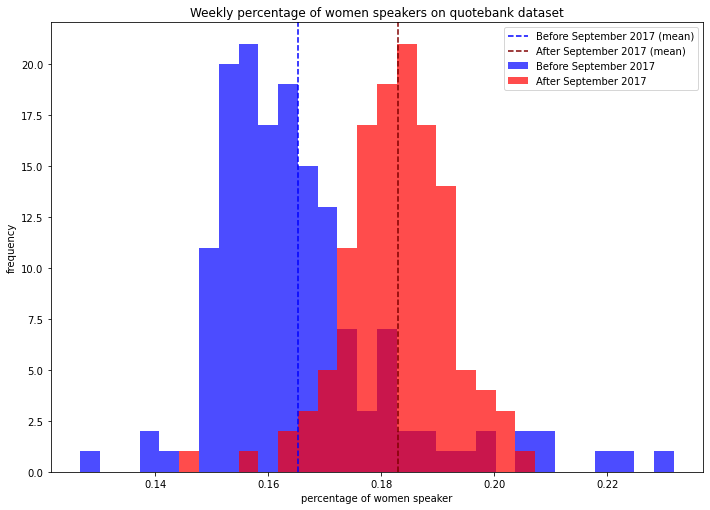

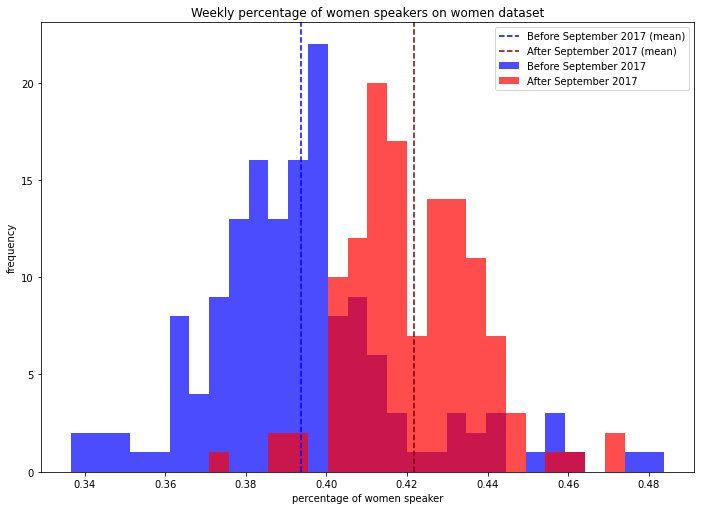

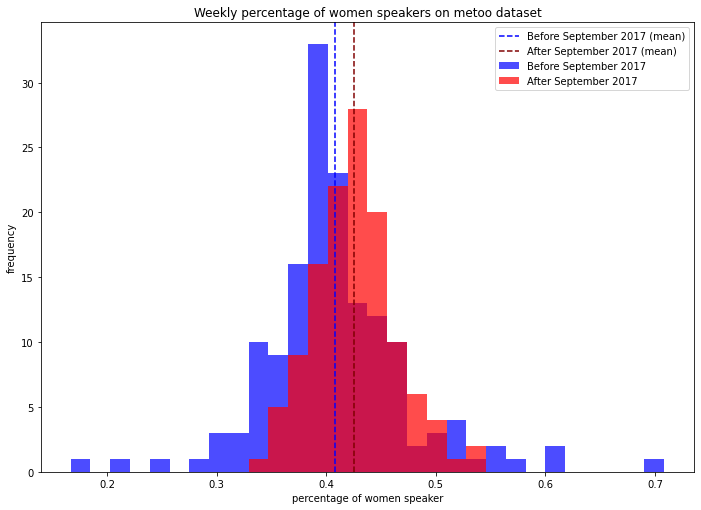

In [ ]:
from percentage_analysis import plot_distrib, plotly_distrib

PATH_DATA = './data/data_nlp/weelky_count/'

datasets = ['quotebank','women','metoo']
years = range(2015,2021)
DF = []

for dataset in datasets:
       #reset frames
       frames = []
       for year in years:

              if dataset == 'quotebank':
                     QUOTES_FILE = PATH_DATA + dataset + f'/{year}_count.csv'
                     df_weekly_count = pd.read_csv(QUOTES_FILE, index_col=0)
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
              else:
                     QUOTES_FILE = PATH_DATA + dataset + f'/quotes-{year}-filtered_weekly_count.json.bz2'
                     df_weekly_count = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', typ='frame')
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
                     
              #remove useless columns (only keeping male and female count)
              useless_columns = list(df_weekly_count.columns)
              useless_columns.remove('male')
              useless_columns.remove('female')
              df_weekly_count.drop(useless_columns, axis=1, inplace=True)

              #adding the percentage of women column
              df_weekly_count['male_female'] = df_weekly_count.male + df_weekly_count.female
              df_weekly_count['percent_women'] = df_weekly_count.female/df_weekly_count.male_female
              df_weekly_count.dropna(inplace=True)

              frames.append(df_weekly_count)

       #create a df with all the weeks from 2015 to 2020
       df_weekly_all = pd.concat(frames)
       df_weekly_all.reset_index(inplace=True)
       df_weekly_all['date'] = pd.date_range(start='1/1/2015', periods=len(df_weekly_all), freq='W')
       #plot the distributions of weekly women percentage
       plot_distrib(df_weekly_all, dataset)
       DF.append(df_weekly_all)
       
#Uncommenting this function will plot the percentage of women from 2015 to 2020
#plotly_distrib(DF, datasets=datasets)


The p-values obtained when performing those t-tests are all inferior to 0.05. We can therefore reject the null hypothesis for a significance level of 5%. In other words, we can reject the hypothesis according to which the weekly average percentage of women speakers have the same distribution (same mean) no matter if it is before or after that the MeToo movement started. Therefore, we can conclude that the difference between the two scenarios is statistically significant: women were given more voic, more mediatic place in the medias after the MeToo movement to talk about the movement iself, but also to tak about themselves and to talk in general. This highlights the influence of MeToo movement on the women's mediatic place.

### B. <u>Sentiment analysis - Compounds for specific dates (women's day and #MeToo tweet) </u><a id="Step-7-B"> </a> 

In [ ]:
import datetime

years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

dates=[(8,3),   # Women-'s Day
       (15,10)] # #MeToo tweet

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        for date in dates:
            begin_year = time()
            day = date[0]
            month = date[1]
            data_path = path.format(year)
            data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
            print("processing path:", data_path[19:])
            reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
            i = 0
            for chunk in reader:
                begin_chunk = time()

                chunk_is_gender = chunk.gender.notna()
                chunk = chunk[chunk_is_gender]
                chunk['gender'] = chunk.gender.apply(lambda x: x[0])
                q_male_female   = chunk[chunk.gender.isin(qid_male+qid_female)].copy()
                q_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)

                # Keep only quotes which are close to selected date
                date_event_begin = datetime.datetime(year, month, day)
                date_event1_end = datetime.datetime(year, month, day+4)
                is_consider = (q_male_female.date>=date_event_begin) & (q_male_female.date<=date_event1_end)
                q_male_female = q_male_female[is_consider]

                # general : count and avg compound per gender per age cat
                male_female_mean = q_male_female[['gender', 'age_cat', 'compound']].groupby(['gender','age_cat']).agg({'sum', 'count', 'std'})
                male_female_mean = male_female_mean.droplevel(0, axis=1)
                male_female_mean['std'] = male_female_mean['std']*male_female_mean['count']
                
                
                # detailed : count and agv compound per gender per age cat per sentiment
                male_female = q_male_female[['gender', 'age_cat','sentiment', 'compound']].groupby(['sentiment','age_cat','gender']).agg({'sum', 'count', 'std'})
                male_female = male_female.droplevel(0, axis=1)
                male_female['std'] = male_female['std']*male_female['count']
                

                if i==0:
                    df_compound_count_detail = male_female.copy()
                    df_compound_count_general= male_female_mean.copy()
                else:
                    df_compound_count_detail = df_compound_count_detail.add(male_female, fill_value=0)
                    df_compound_count_general = df_compound_count_general.add(male_female_mean, fill_value=0)
                print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
                i += 1

            # general : count and avg compound per gender per age cat
            df_compound_count_general['mean'] = df_compound_count_general['sum']/df_compound_count_general['count']
            df_compound_count_general['std']  = df_compound_count_general['std']/df_compound_count_general['count']
            df_compound_count_general.drop(columns=['sum'], inplace=True)
            new_file_path_general = data_path[:-9] + f'_compounds_per_gender_age_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_general, 'wb') as file:
                df_compound_count_general.reset_index().to_json(file, orient='records', lines=True)

            # detailed
            df_compound_count_detail['mean'] = df_compound_count_detail['sum']/df_compound_count_detail['count']
            df_compound_count_detail['std']  = df_compound_count_detail['std']/df_compound_count_detail['count']
            df_compound_count_detail.drop(columns=['sum'], inplace=True)
            new_file_path_detail = data_path[:-9] + f'_compounds_per_gender_age_sentiment_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_detail, 'wb') as file:
                df_compound_count_detail.reset_index().to_json(file, orient='records', lines=True)
        
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

In [ ]:
from compound_analysis import generate_barplot

datasets = ['women', 'metoo']
years = [2015, 2017, 2019]
PATH_DATA = './data/data_nlp/compound/'

generate_barplot(PATH_DATA, datasets, years)

***HERE IS A BARPLOT:*** It may not be visible on the github website but it should be visible on an IDE by downloading the notebook.

### C. <u>Statistical analysis of sentiment compounds evolution for different genres and age categories </u><a id="Step-7-C"> </a> 

Here, we compare three year here: before #MeToo movement (2015), 1st #MeToo tweet (2017) and later (2019)\
We will generate T-test on each combinaisons of those years in order to evaluate #MeToo movement influence on women's mediatisation

In [6]:
# create Dataset for T-test on compounds
p_male_general, p_female_general = helper.ttest_list_general(YEARS_CMP, qid_male, qid_female)

In [10]:
print('\nP-Values from T-test on compounds:\n')
helper.print_p_values_comp(p_male_general, p_female_general)


P-Values from T-test on compounds:

| gender |    age   ||  2015 vs 2017  |  2017 vs 2019  |  2015 vs 2019  |
|--------|----------||----------------|----------------|----------------|
|        |  0 -> 40 ||      0.44      |      0.44      |      0.14      |
|  male  | 41 -> 60 ||     0.0018     |      0.042     |      0.31      |
|        | 61 -> ++ ||      0.44      |     3.6e-07    |     6.1e-05    |
|--------|----------||----------------|----------------|----------------|
|        |  0 -> 40 ||    9.8e-05     |     2.5e-22    |    2.1e-07     |
| female | 41 -> 60 ||    7.7e-12     |     2.1e-25    |     0.004      |
|        | 61 -> ++ ||      0.71      |     0.00023    |     0.0024     |


Note: All values smaller than 0.05, it statiscally suggest that the mean of the distribution are different.